# Conversion between integer and floating point images in scikit-image

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Let's assume we have a detector which gives us an analogue signal for each pixel. Without loss of
generality, the signal is shifted and scaled to be in the range `[0.0, 1.0]`. It is not relevant if
the right (or left) edge is inclusive or exclusive.

We could use a random image here, but let's use a linear ramp, so we can better see the effects of
quantization.

In [2]:
img_float = np.linspace(0, 1, 10_000).reshape(100, 100)
np.histogram(img_float, bins=4, range=(0, 1))

(array([2500, 2500, 2500, 2500]), array([0.  , 0.25, 0.5 , 0.75, 1.  ]))

As expected, the histogram with four bins shows a uniform distribution of values.

When we now apply `skimage.util.img_as_ubyte`, we get the following histogram:

In [3]:
from skimage.util import img_as_ubyte
from skimage.util.dtype import _convert

img_uint8_ski = img_as_ubyte(img_float)
np.histogram(img_uint8_ski, bins=4, range=(0, 255))

(array([2490, 2510, 2510, 2490]),
 array([  0.  ,  63.75, 127.5 , 191.25, 255.  ]))

As we can see, the two edge bins get lower counts compared to the two inner bins.
We can fix that by setting `uniform=True` in the `_convert` function used internally by
`img_as_ubyte`:

In [4]:
img_uint8_ski_uni = img_as_ubyte(img_float)
img_uint8_ski_uni = _convert(img_float, np.uint8, uniform=True)
np.histogram(img_uint8_ski_uni, bins=4, range=(0, 255))

(array([2500, 2500, 2500, 2500]),
 array([  0.  ,  63.75, 127.5 , 191.25, 255.  ]))

When you look into `_convert`, you see that setting `uniform=True` basically uses a different scaling value (256 instead of 255) and clips the values to the valid range for a `uint8`:

In [5]:
img_uint8_man = np.clip(img_float * 256, 0, 255).astype(np.uint8)
np.histogram(img_uint8_man, bins=4, range=(0, 255))

(array([2500, 2500, 2500, 2500]),
 array([  0.  ,  63.75, 127.5 , 191.25, 255.  ]))

Now, the bins are distributed evenly again, because this conversion uses the same bin size for all
four bins.

> Note: Clipping is only necessary if the input interval includes the the right edge 1.0.

### Question 1: Why is `uniform=True` not the default behavior since it gives IMHO more accurate results?

My guess: prior art & backward compatibility

### Question 2: Should we introduce a way to switch the default behavior to use `uniform=True`?

```python
UNIFORM_CONVERSION_DEFAULT = False  # flip this to True in 2030 ;-)

def _convert(image, dtype, force_copy=False, uniform=None):
    if uniform is None:
        uniform = UNIFORM_CONVERSION_DEFAULT
    ...
```

When we now convert back to float (also by looking at the code of `_convert`), we see that the `uniform` parameters has no effect:

In [6]:
img_float_ski = _convert(img_uint8_ski_uni, np.float32, uniform=False)
img_float_ski_uni = _convert(img_uint8_ski_uni, np.float32, uniform=True)

np.ptp(img_float_ski - img_float_ski_uni)

np.float32(0.0)

When we compare the initial float image `img_float` with the twice converted float image
`img_float_ski`, we see the result of the different scaling ranges:

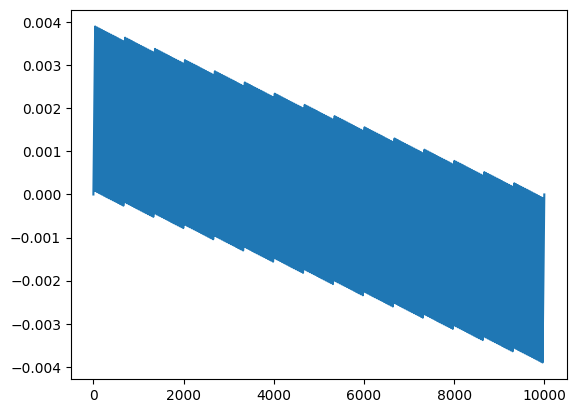

In [7]:
_ = plt.plot((img_float - img_float_ski).flatten())

If we do the conversion manually again using the range of `[0, 256]`, we get a smaller error
without the drift:

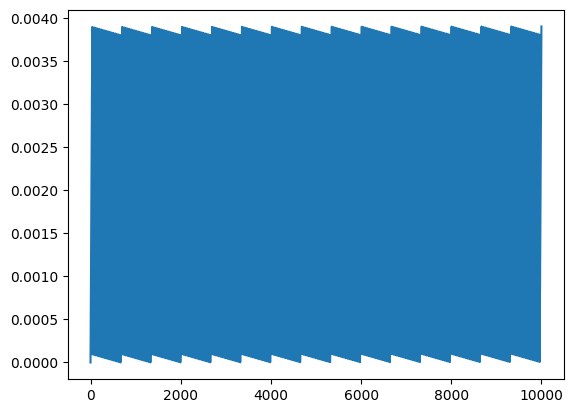

In [8]:
img_float_man = img_uint8_man / 256.0
_ = plt.plot((img_float - img_float_man).flatten())

We can improve this even further by shifting the float values to the center of each "integer bin":

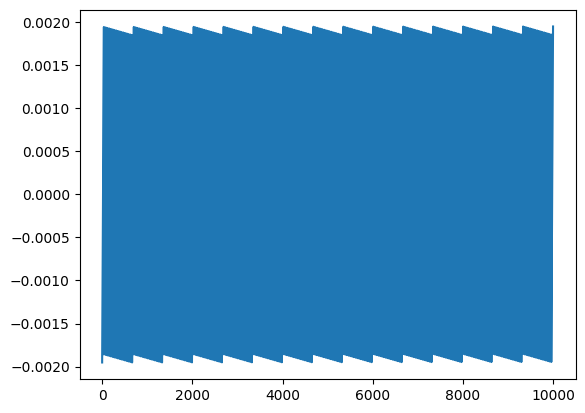

In [9]:
img_float_man = img_uint8_man / 256.0 + 0.5 / 256
_ = plt.plot((img_float - img_float_man).flatten())

Again, the histogram shows a perfect uniform distribution:

In [10]:
np.histogram(img_float_man, bins=4, range=(0, 1))

(array([2500, 2500, 2500, 2500]), array([0.  , 0.25, 0.5 , 0.75, 1.  ]))

### Question 3: Should we add this treatment to `_convert` when converting from integer to float with `uniform=True`?